In [1]:
import math
%load_ext autoreload
%autoreload 2
exec(open('init_notebook.py').read())
from matplotlib import pyplot as plt
from highD.HighD import HighD
from highD.Filter import Filter
from highD.Plot import Plot
from highD.Visualizer import GIF
from highD.helper import *

current working dirC:\Users\abjaw\Documents\GitHub\CogMod-driver-behavior-model\highd_tools


In [2]:

class IntelligentDriverModel():
    def __init__(self, desired_velocity, safe_time_headway, max_acceleration, comfort_deceleration, acceleration_exponent, minimum_distance, vehicle_length, far_distance):
        self.desired_velocity = desired_velocity
        self.safe_time_headway = safe_time_headway
        self.max_acceleration = max_acceleration
        self.comfort_deceleration = comfort_deceleration
        self.acceleration_exponent = acceleration_exponent
        self.minimum_distance = minimum_distance
        self.vehicle_length = vehicle_length
        self.far_distance = far_distance

    def update(self, ego_velocity, preceding_vehicle_velocity, distance_delta):
        self.ego_velocity = ego_velocity
        self.preceding_vehicle_velocity = preceding_vehicle_velocity
        self.distance_delta = distance_delta
        self.next_acceleration = self.calc_acceleration()

    def calc_acceleration(self):
        acceleration = math.pow((self.ego_velocity / self.desired_velocity), self.acceleration_exponent)
        deceleration = math.pow(self.calc_desired_gap() / min(self.far_distance, self.distance_delta), 2)
        return float(self.max_acceleration * (1 - acceleration - deceleration))

    def calc_desired_gap(self):
        del_v = (self.ego_velocity - self.preceding_vehicle_velocity)
        ab = self.max_acceleration * self.comfort_deceleration
        c = ((self.safe_time_headway * self.ego_velocity) + ((self.ego_velocity * del_v) / (2 * math.sqrt(ab))))
        return float(self.minimum_distance + max(0, c))


In [30]:
ids = ["01", "02"]
highD = HighD(ids, DATA_DIRECTORY)

dataset_id = 1
_, tMeta, tracks = highD.get_dataframe_tuple(dataset_id)
df = highD.get_combined_dataframe(dataset_id)
image = highD.get_image(dataset_id)
print(df.columns)

Loaded data and image for dataset 01.
Loaded data and image for dataset 02.
Index(['dataset_id', 'locationId', 'frame', 'id', 'class', 'drivingDirection',
       'laneId', 'x', 'y', 'width', 'height', 'xVelocity', 'yVelocity',
       'xAcceleration', 'yAcceleration', 'frontSightDistance',
       'backSightDistance', 'dhw', 'thw', 'ttc', 'precedingXVelocity',
       'precedingId', 'followingId', 'leftPrecedingId', 'leftAlongsideId',
       'leftFollowingId', 'rightPrecedingId', 'rightAlongsideId',
       'rightFollowingId'],
      dtype='object')


In [5]:
follow_meta = Filter.filter_vehicle_follow_scenario(df, 
                                      ego_type='Car', 
                                      preceding_type='Car',
                                      minDuration=5, 
                                      minStartDistance=50,
                                      maxStartDistance=100)

print(follow_meta.shape)
follow_meta.head()

Filtering vehicle follow scenario Car Car 5 50 100
total actors 1047, filtered actors 730, ratio 0.6972301814708691
total actors 1047, filtered actors 730, ratio 0.6972301814708691
total scenario 22, filtered scenario 7, ratio 0.3181818181818182
(7, 8)


,ego_id,preceding_id,start_frame,end_frame,duration,start_distance,max_distance,min_distance
4,50,47,994,1211,8.68,61.680066,61.850137,50.781906
7,386,380,7878,8100,8.88,99.580025,99.580025,51.590035
10,524,521,10480,10676,7.84,81.870748,108.920017,81.870748
13,680,678,14277,14510,9.32,68.200188,81.370325,68.200188
14,724,722,15243,15454,8.44,60.811251,142.144027,60.811251


In [6]:
import numpy as np

scenario_id = 0
print('scenario id ', scenario_id)
scenario_follow_meta = follow_meta.iloc[scenario_id]
ego_id = int(scenario_follow_meta['ego_id'])
preceding_id = int(scenario_follow_meta['preceding_id'])
start_frame = int(scenario_follow_meta['start_frame'])
end_frame = int(scenario_follow_meta['end_frame'])
print(ego_id, preceding_id, start_frame, end_frame)

scenario id  0
50 47 994 1211


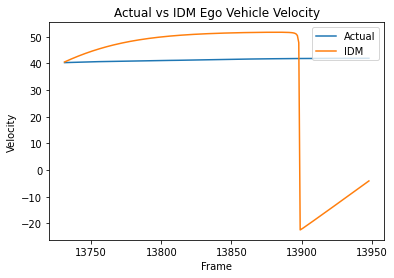

In [25]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

# Assume df is your DataFrame

# get data for ego and preceding vehicle
ego_df = df[(df['id'] == ego_id) & df['frame'].between(start_frame, end_frame)]
prec_df = df[(df['id'] == preceding_id) & df['frame'].between(start_frame, end_frame)]

# Initialize IDM with desired parameters
desired_velocity = ego_df['xVelocity'].max() + 10  # Desired speed is 10 m/s higher
safe_time_headway = 0.5
max_acceleration = ego_df[ego_df['xAcceleration'] > 0]['xAcceleration'].max()
comfort_deceleration = abs(ego_df[ego_df['xAcceleration'] < 0]['xAcceleration'].max())
acceleration_exponent = 4.0
minimum_distance = 1.0
vehicle_length = prec_df.iloc[0]['width'] # assuming the width is the length of the vehicle
far_distance = 100.0

T = 0.04
idm = IntelligentDriverModel(desired_velocity, safe_time_headway, max_acceleration, comfort_deceleration, acceleration_exponent, minimum_distance, vehicle_length, far_distance)

# Create a test scenario
ego_velocity_idm = [ego_df['xVelocity'].iloc[0]]
ego_x = ego_df.iloc[0]['x']
for _, prec in prec_df.iterrows():
    prec_velocity = prec['xVelocity']
    distance_delta = abs(ego_x - prec['x'])
    
    idm.update(ego_velocity_idm[-1] if ego_velocity_idm else desired_velocity, prec_velocity, distance_delta)
    new_velocity = (ego_velocity_idm[-1] if ego_velocity_idm else desired_velocity) + idm.next_acceleration  # Calculate next velocity

    # Update ego vehicle position based on new_velocity assuming moving in a straight line
    ego_x = ego_x + new_velocity * T  # All movement is in x direction
    ego_velocity_idm.append(new_velocity)

plt.plot(ego_df.index, ego_df['xVelocity'], label='Actual')
plt.plot(ego_df.index, ego_velocity_idm[1:], label='IDM')
plt.legend(loc='upper right')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title('Actual vs IDM Ego Vehicle Velocity')
plt.show()


In [29]:
# Simulation
ego_velocity_idm = []
ego_x = [ego_df.iloc[0]['x']]  # Initial position of ego vehicle
prec_x = prec_df['x'].values.tolist()  # Preceding vehicle position list

for i, prec_velocity in enumerate(prec_df['xVelocity']):
    distance_delta = abs(ego_x[-1] - prec_x[i])

    idm.update(ego_velocity_idm[-1] if ego_velocity_idm else desired_velocity, prec_velocity, distance_delta)
    new_velocity = (ego_velocity_idm[-1] if ego_velocity_idm else desired_velocity) + idm.next_acceleration  # Calculate next velocity

    # Update ego vehicle position based on new_velocity assuming moving in a straight line
    ego_x.append(ego_x[-1] + new_velocity)  # All movement is in x direction
    ego_velocity_idm.append(new_velocity)


In [31]:
# Load the highway image
highway_image = highD.get_image(dataset_id)

# Calculate the lane position (y coordinate) for the ego vehicle
# Assuming lane_width is a predefined constant representing the width of a lane in the image
lane_id = ego_df.iloc[0]['laneId']
lane_position = lane_id * lane_width

# Generate the frames
frames = []
for i in range(len(ego_x)):
    # Plot the highway image
    fig, ax = plt.subplots(figsize=(4,20))
    ax.imshow(highway_image)
    
    # Draw the ego vehicle as a rectangle
    ego_rect = patches.Rectangle((ego_x[i], lane_position), 10, 20, facecolor='green')  
    ax.add_patch(ego_rect)
    
    # Draw the preceding vehicle as a rectangle
    # Here we assume that the preceding vehicle is always in the same lane as the ego vehicle
    prec_rect = patches.Rectangle((prec_x[i], lane_position), 10, 20, facecolor='blue')
    ax.add_patch(prec_rect)

    # Save the current frame
    filepath = f'frame_{i}.png'
    plt.savefig(filepath)
    frames.append(filepath)

    plt.close(fig)

# Create the gif
images = [imageio.imread(frame) for frame in frames]
imageio.mimsave('vehicle_movement.gif', images, fps=10)

# Clean up the frames
for frame in frames:
    os.remove(frame)


NameError: name 'lane_width' is not defined